In [65]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics

Bag of words prototype on a small sample of the data

In [147]:
def folder_list_pd(path,file_list,num=5000): #take num files
    '''
    Return dataframe with texts
    '''
    filelist = os.listdir(path)
    filelist = [x for x in filelist if x in file_list]
    appeals = []
    appeals_df = pd.DataFrame(columns = ['Text','File'])
    files = []
    count = 0
    for infile in filelist:  
        count+=1
        file = os.path.join(path,infile)
        f = open(file)
        lines = f.read().strip().replace('\n',' ').replace('\t', ' ')
        appeals.append(lines)
        files.append(str(infile))
        
        if count == num:
            break
            
    appeals_df.Text = appeals  
    appeals_df.File = files
    
    return appeals_df

In [160]:
def match_target(data):
    '''
    Add target variable
    '''
    keys = pd.read_csv('file_target.csv')
    merged = data.merge(keys, on='File', how='left')
    merged.drop(['File','Unnamed: 0'], axis =1,inplace=True)
    
    return merged

In [ ]:
if __name__ == '__main__':
    path = 'text_appeals'
    file_id = list(pd.read_csv('file_target.csv').File)
    appeals = folder_list_pd(path,file_id)
    merged = match_target(appeals)
    X = pd.DataFrame(merged['Text'])
    Y = pd.DataFrame(merged['Y'])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [154]:
#Read map from file to outcome
file_id = list(pd.read_csv('file_target.csv').File)

In [155]:
#Read appeals into a dataframe
appeals = folder_list_pd(path,file_id)

In [161]:
#Match appeals to outcomes
merged = match_target(appeals)

In [267]:
#Split into test and train
X = pd.DataFrame(merged['Text'])
Y = pd.DataFrame(merged['Y'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [285]:
merged.to_csv('merged.csv')

### Read data from file

In [2]:
merged = pd.read_csv('merged.csv')

X = pd.DataFrame(merged['Text'])
Y = pd.DataFrame(merged['Y'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

### Models including all words
This will create leakage as outcome is included in the training set. However, it is still useful for the first iteration to ensure the model works as expected

In [213]:
#Create vectorizers
count_vect = CountVectorizer(min_df=1, stop_words='english', binary='True')

#Convert a collection of text documents to a matrix of token counts
X_vect = count_vect.fit(X_train['Text'])

#Transform the training and test data to sparse format
vect_train = X_vect.transform(X_train['Text'])
vect_test = X_vect.transform(X_test['Text'])

In [176]:
#See the vocabulary
X_vect.vocabulary_

{'people': 20082,
 'nelson': 18911,
 '2008': 4331,
 'ny': 19226,
 'slip': 23733,
 'op': 19452,
 '04232': 1414,
 '51': 4889,
 'ad3d': 5808,
 '1137': 3367,
 'appellate': 6488,
 'division': 11358,
 'department': 10772,
 'published': 21116,
 'new': 18947,
 'york': 27104,
 'state': 24161,
 'law': 16788,
 'reporting': 21992,
 'bureau': 8163,
 'pursuant': 21183,
 'judiciary': 16050,
 '431': 4759,
 'corrected': 9884,
 'wednesday': 26667,
 'july': 16066,
 '16': 3911,
 'respondent': 22098,
 'jonathan': 15998,
 'appellant': 6486,
 'alexander': 6102,
 'bloomstein': 7648,
 'hillsdale': 14615,
 'weeden': 26670,
 'wetmore': 26736,
 'district': 11330,
 'attorney': 6852,
 'elmira': 11920,
 'john': 15973,
 'trice': 25486,
 'counsel': 9950,
 'rose': 22501,
 'appeal': 6472,
 'judgment': 16044,
 'county': 9970,
 'court': 9979,
 'chemung': 8848,
 'buckley': 8106,
 'rendered': 21927,
 'october': 19330,
 '17': 4002,
 '2005': 4325,
 'verdict': 26260,
 'convicting': 9791,
 'defendant': 10557,
 'crime': 10079,
 

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12

In [7]:

def plot_roc(actual,forecast,name):
    
    #ROC
    fpr, tpr, thresholds = metrics.roc_curve(actual, forecast)

    #AUC
    aucc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = name + ' AUC: '+str(round(aucc, 4)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.grid(True)
    plt.legend(loc = 'lower right', title='AUC')



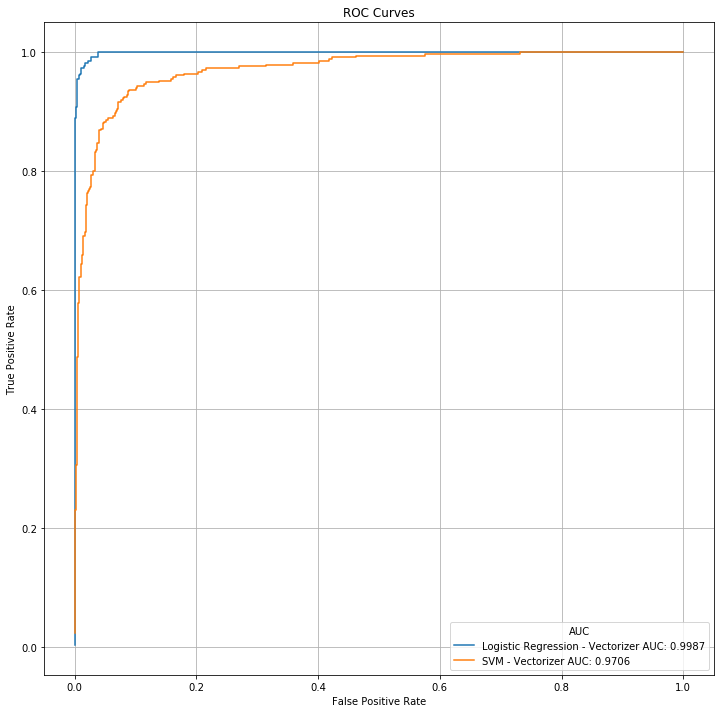

In [217]:

#Fitting logistic regression to vectorizer
logistic = LogisticRegression(random_state=33)

logistic.fit(vect_train, Y_train['Y'])
logistic_vect_fcst = logistic.predict_proba(vect_test)[:,1]

#Fitting Naive Bayes to both vectorizers
sv = svm.SVC(probability=True,random_state=33)

sv.fit(vect_train, Y_train['Y'])
sv_vect_fcst = sv.predict_proba(vect_test)[:,1]

    
plot_roc(Y_test, logistic_vect_fcst,'Logistic Regression - Vectorizer')

plot_roc(Y_test, sv_vect_fcst,'SVM - Vectorizer')

In [41]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\tAffirmed\t\t\tModified")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [262]:
show_most_informative_features(X_vect,logistic)

	-3.7946	affirmed       		4.2756	dismissed      
	-0.6806	county         		3.8127	modified       
	-0.6754	unanimously    		2.7023	reversed       
	-0.6321	court          		1.2088	vacating       
	-0.6095	appealed       		0.9822	concede        
	-0.5631	withdraw       		0.9773	remitted       
	-0.5161	decline        		0.7616	matter         
	-0.4190	judgment       		0.7461	modify         
	-0.3724	ordered        		0.6850	nobis          
	-0.3479	murder         		0.6850	coram          
	-0.3435	opinion        		0.6690	writ           
	-0.3382	ny2d           		0.6466	justice        
	-0.3297	pleaded        		0.6296	extent         
	-0.3249	satisfaction   		0.5347	error          
	-0.3220	defendant      		0.5264	indictment     
	-0.3129	district       		0.5046	indicated      
	-0.3088	contention     		0.4753	reargument     
	-0.2945	460            		0.4751	granted        
	-0.2937	furthermore    		0.4392	reducing       
	-0.2865	costs          		0.4304	dismissing     


###  Bag of words excluding leakage

In [3]:
#Clean keywords
X_train_ex = X_train.Text.replace(['affirmed|dismissed|modified|reversed'],'', regex=True)
X_test_ex = X_test.Text.replace(['affirmed|dismissed|modified|reversed'],'', regex=True)

In [39]:
#Create vectorizers
count_vect_ex = CountVectorizer(min_df=1, stop_words='english', binary='True')

#Convert a collection of text documents to a matrix of token counts
X_vect_ex = count_vect_ex.fit(X_train_ex)

#Transform the training and test data to sparse format
vect_train_ex = X_vect_ex.transform(X_train_ex)
vect_test_ex = X_vect_ex.transform(X_test_ex)

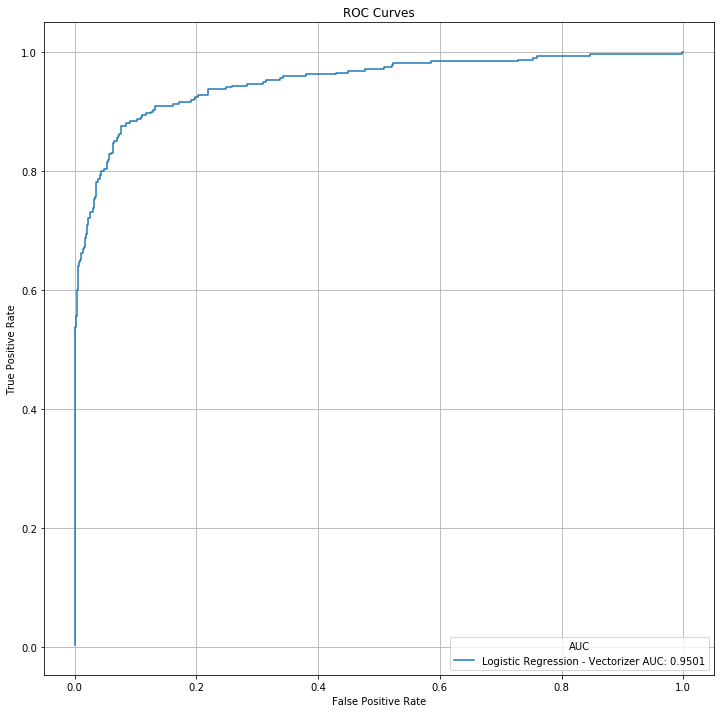

In [40]:
#Fitting logistic regression to vectorizer
logistic_ex = LogisticRegression(random_state=33)

logistic_ex.fit(vect_train_ex, Y_train['Y'])
logistic_vect_fcst_ex = logistic_ex.predict_proba(vect_test_ex)[:,1]
   
plot_roc(Y_test, logistic_vect_fcst_ex,'Logistic Regression - Vectorizer')


In [41]:
show_most_informative_features(X_vect_ex,logistic_ex)

	-1.2916	appealed       		1.7997	concede        
	-0.9793	unanimously    		1.7954	remitted       
	-0.9781	county         		1.7346	vacating       
	-0.9756	decline        		1.3429	matter         
	-0.9601	court          		1.2268	modify         
	-0.8450	withdraw       		1.1468	said           
	-0.6905	contention     		1.1223	indicated      
	-0.6844	460            		1.0622	extent         
	-0.6633	permissible    		1.0473	vacated        
	-0.6578	properly       		0.9849	granted        
	-0.6164	ordered        		0.9428	dismissing     
	-0.6122	satisfaction   		0.9199	nobis          
	-0.5871	opinion        		0.9199	coram          
	-0.5574	perceive       		0.9196	stipulation    
	-0.5368	unpreserved    		0.9078	indictment     
	-0.5290	excessive      		0.8538	writ           
	-0.5207	disagree       		0.8484	agree          
	-0.5107	lahtinen       		0.8225	moot           
	-0.5076	lv             		0.8116	justice        
	-0.5008	murder         		0.7885	determination  


### Bi-gram Bag of Words

In [14]:
#Create vectorizers
count_vect_bi = CountVectorizer(min_df=1, stop_words='english', ngram_range=(2, 2), binary='True')

#Convert a collection of text documents to a matrix of token counts
X_vect_bi = count_vect_bi.fit(X_train_ex)

#Transform the training and test data to sparse format
vect_train_bi = X_vect_bi.transform(X_train_ex)
vect_test_bi = X_vect_bi.transform(X_test_ex)

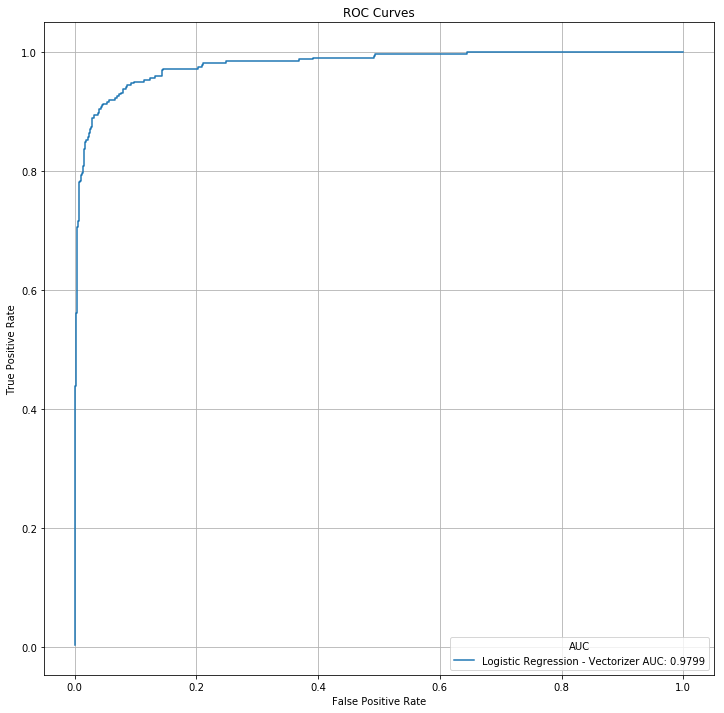

In [15]:
#Fitting logistic regression to vectorizer
logistic_bi = LogisticRegression(random_state=33)

logistic_bi.fit(vect_train_bi, Y_train['Y'])
logistic_vect_fcst_bi = logistic_bi.predict_proba(vect_test_bi)[:,1]
   
plot_roc(Y_test, logistic_vect_fcst_bi,'Logistic Regression - Vectorizer')

In [60]:
show_most_informative_features(X_vect_bi,logistic_bi)

	Affirmed			Modified
	-1.2582	ordered judgment		1.8804	unanimously law
	-1.0701	appealed unanimously		1.4742	matter remitted
	-0.9272	appellant judgment		1.4121	judgment law   
	-0.9073	judgment appealed		1.0018	new trial      
	-0.8992	unanimously memorandum		0.9926	matter discretion
	-0.6551	county court   		0.9631	discretion justice
	-0.5589	unanimously present		0.9095	appellant motion
	-0.5217	york respondent		0.8341	denied present 
	-0.4577	respondent judgment		0.7484	coram nobis    
	-0.4551	supreme court  		0.7351	writ error     
	-0.4431	unanimously opinion		0.7351	error coram    
	-0.4109	properly denied		0.7147	extent indicated
	-0.3930	defendant contention		0.7075	law vacating   
	-0.3784	district attorney		0.6845	ordered said   
	-0.3715	excessive ordered		0.6790	people concede 
	-0.3646	unanimously costs		0.6546	law matter     
	-0.3557	motion relieved		0.6321	unanimously matter
	-0.3513	unanimously counsel		0.6146	remitted county
	-0.3402	excessive people		0.5808	said app

### 3-Gram

In [61]:
#Create vectorizers
count_vect_tri = CountVectorizer(min_df=1, stop_words='english', ngram_range=(3, 3), binary='True')

#Convert a collection of text documents to a matrix of token counts
X_vect_tri = count_vect_tri.fit(X_train_ex)

#Transform the training and test data to sparse format
vect_train_tri = X_vect_tri.transform(X_train_ex)
vect_test_tri = X_vect_tri.transform(X_test_ex)

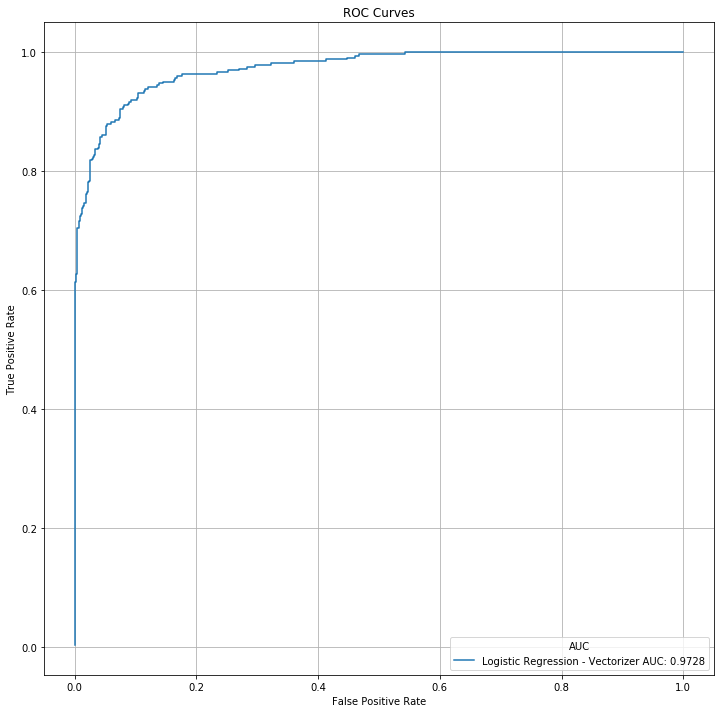

In [62]:
#Fitting logistic regression to vectorizer
logistic_tri = LogisticRegression(random_state=33)

logistic_tri.fit(vect_train_tri, Y_train['Y'])
logistic_vect_fcst_tri = logistic_tri.predict_proba(vect_test_tri)[:,1]
   
plot_roc(Y_test, logistic_vect_fcst_tri,'Logistic Regression - Vectorizer')

In [63]:
show_most_informative_features(X_vect_tri,logistic_tri)

	Affirmed			Modified
	-1.2428	appealed unanimously memorandum		1.5716	ordered judgment law
	-1.1268	ordered judgment appealed		1.2898	matter discretion justice
	-1.0004	judgment appealed unanimously		1.0139	appealed unanimously law
	-0.8308	appealed unanimously present		0.9502	writ error coram
	-0.6879	appellant judgment supreme		0.9502	error coram nobis
	-0.6397	unanimously memorandum defendant		0.8002	remitted county court
	-0.6379	ordered judgment defendant		0.7969	unanimously matter discretion
	-0.5858	new york respondent		0.7919	matter remitted county
	-0.5265	unanimously opinion order		0.7622	years unanimously law
	-0.4884	counsel respondent appeal		0.7494	unanimously law extent
	-0.4841	concur ordered judgment		0.7146	remitted supreme court
	-0.4417	relieved assignment granted		0.7146	matter remitted supreme
	-0.4396	degree ordered judgment		0.6975	ordered said appeal
	-0.4266	opinion order filed		0.6578	people correctly concede
	-0.3935	counsel motion relieved		0.6113	excessive

#### TF-IDF

In [67]:
#Create vectorizers
tfidf = TfidfVectorizer(min_df=1, stop_words='english', binary='True')

#Convert a collection of text documents to a matrix of token counts
X_tfidf = tfidf.fit(X_train_ex)

#Transform the training and test data to sparse format
tfidf_train = X_tfidf.transform(X_train_ex)
tfidf_test = X_tfidf.transform(X_test_ex)

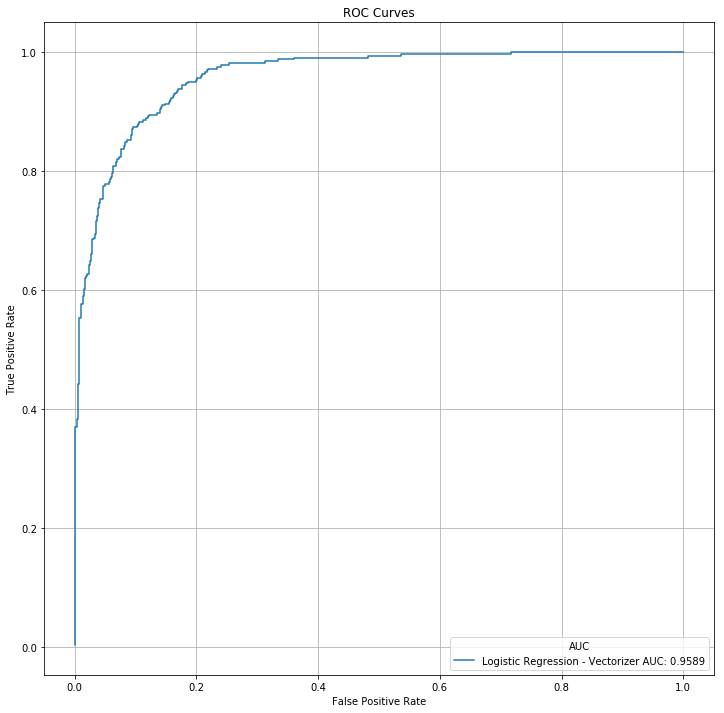

In [69]:
#Fitting logistic regression to vectorizer
logistic_tf = LogisticRegression(random_state=33)

logistic_tf.fit(tfidf_train, Y_train['Y'])
logistic_tf_fcst = logistic_tf.predict_proba(tfidf_test)[:,1]
   
plot_roc(Y_test, logistic_tf_fcst,'Logistic Regression - Vectorizer')

In [70]:
show_most_informative_features(X_tfidf,logistic_tf)

	Affirmed			Modified
	-1.8716	unanimously    		4.7704	remitted       
	-1.6970	appealed       		4.3239	matter         
	-1.6487	contention     		3.7941	vacating       
	-1.5260	unpreserved    		3.7053	nobis          
	-1.4548	withdraw       		3.7053	coram          
	-1.3564	properly       		3.6791	writ           
	-1.3316	judgment       		3.1366	concede        
	-1.3282	appeal         		3.1061	error          
	-1.2431	degree         		2.8264	vacated        
	-1.2222	plea           		2.5169	decision       
	-1.2186	county         		2.5010	modify         
	-1.2032	imposing       		2.4334	proceedings    
	-1.1898	excessive      		2.2644	indictment     
	-1.1615	convicting     		2.2331	reargument     
	-1.1565	record         		2.2095	remit          
	-1.1417	court          		1.9542	accordingly    
	-1.1261	ny2d           		1.8518	dismissing     
	-1.0965	rendered       		1.7909	reverse        
	-1.0939	district       		1.7365	affirming      
	-1.0681	counsel        		1.6922	745            

#### TFIDF Bigram

In [71]:
#Create vectorizers
tfidf_bi = TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(2, 2),binary='True')

#Convert a collection of text documents to a matrix of token counts
X_tfidf_bi = tfidf_bi.fit(X_train_ex)

#Transform the training and test data to sparse format
tfidf_train_bi = X_tfidf_bi.transform(X_train_ex)
tfidf_test_bi = X_tfidf_bi.transform(X_test_ex)

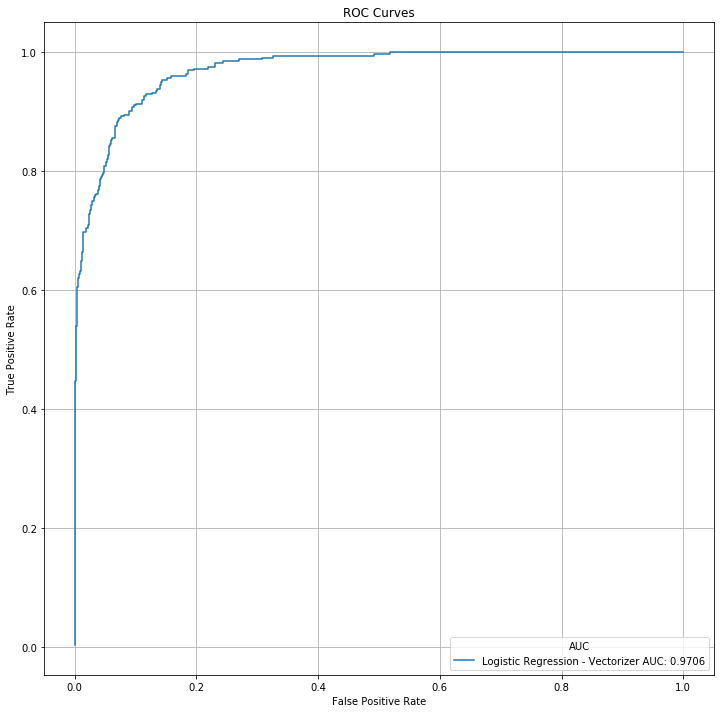

In [73]:
#Fitting logistic regression to vectorizer
logistic_tf_bi = LogisticRegression(random_state=33)

logistic_tf_bi.fit(tfidf_train_bi, Y_train['Y'])
logistic_tf_fcst_bi = logistic_tf_bi.predict_proba(tfidf_test_bi)[:,1]
   
plot_roc(Y_test, logistic_tf_fcst_bi,'Logistic Regression - Vectorizer')

In [74]:
show_most_informative_features(X_tfidf_bi,logistic_tf_bi)

	Affirmed			Modified
	-1.9756	ordered judgment		3.3674	matter remitted
	-1.8849	unanimously memorandum		3.1621	unanimously law
	-1.6519	judgment appealed		2.8367	coram nobis    
	-1.4557	appealed unanimously		2.8278	writ error     
	-1.4310	respondent appeal		2.8278	error coram    
	-1.4285	appeal defendant		2.7895	appellant motion
	-1.4133	appellant judgment		2.6790	denied present 
	-1.2888	plea guilty    		2.5021	judgment law   
	-1.2648	imposing sentence		2.0708	motion writ    
	-1.2461	defendant contention		1.9364	nobis denied   
	-1.2309	counsel appellant		1.8051	matter discretion
	-1.2176	supreme court  		1.7920	discretion justice
	-1.1982	judgment supreme		1.7311	new trial      
	-1.1649	sentence ordered		1.6696	judgment matter
	-1.1579	court properly 		1.6246	law vacating   
	-1.1274	district attorney		1.5896	remit matter   
	-1.0820	counsel respondent		1.5845	remitted county
	-1.0798	contrary defendant		1.5197	law matter     
	-1.0719	unanimously present		1.5163	vacating sente